# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 32.0 MB/s 
     |████████████████████████████████| 182 kB 57.8 MB/s 
     |████████████████████████████████| 7.6 MB 51.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 9.8 MB/s 
     |████████████████████████████████| 115 kB 62.7 MB/s 
     |████████████████████████████████| 212 kB 56.0 MB/s 
     |████████████████████████████████| 127 kB 24.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(5600)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2TokenizerFast, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

Sun Nov 20 18:43:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others.

https://huggingface.co/datasets/amazon_us_reviews

In [3]:
from datasets import load_dataset

datasets = load_dataset("amazon_us_reviews", 'Video_Games_v1_00')

Generating train split:   0%|          | 0/1785997 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/.cache/huggingface/datasets/amazon_us_reviews/Video_Games_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date'],
        num_rows: 1785997
    })
})

In [5]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        # print(column)

        if isinstance(typ, ClassLabel):
            print(column, typ.names)
            df[column] = df[column].transform(lambda i: typ.names[i])
    # display(HTML(df.to_html()))
    display(df.head(10))
    return df


In [6]:
sample_df = show_random_elements(datasets['train'], num_examples = 1000)
review_df = sample_df['review_body'].copy()

vine ['N', 'Y']
verified_purchase ['N', 'Y']


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,34523935,RPVGWJVO2UW8G,B00000JIUG,672471605,Lunar: Silver Star Story Complete,Video Games,5,1,1,N,N,A classic,I recommend this game to anyone who considers ...,2002-10-02
1,US,52827786,R29YC0UAC8SGV4,B0041OWQTO,339011374,Borderlands,Video Games,5,1,1,N,Y,"Really well designed game, addictive",I normally don't play this style of game (shoo...,2011-11-19
2,US,14889915,RV1UKVK315SHG,B000B6MLU0,793022417,Xbox 360 Head Set Communicator,Video Games,5,0,4,N,N,good and new,"the item was in plastic wrap good, but took ab...",2007-11-05
3,US,22232349,R1SLHFQUHPF5B,B006PP404Q,982545761,PlayStation Vita Protective Film - Two Pack,Video Games,3,0,0,N,Y,Not as good,"So I bought this to try, struggled with air bu...",2012-12-01
4,US,7196738,R2N7H4DZI18ZCE,B003XWD1G2,690812874,HDE Nintendo Switch / Wii U / Wii USB to LAN N...,Video Games,5,0,0,N,Y,worked first go.,had power off at powerpoint plugged in the ad...,2013-02-27
5,US,23578107,R9UZ6XL5MR0LH,B00F2Y1C9M,803220768,dreamGEAR Xbox One 3.0 USB Hub,Video Games,5,0,0,N,Y,Five Stars,works as it should,2015-03-08
6,US,42079021,R1FIJXU4KD3O1B,B0030GBTYC,488222977,Calling,Video Games,3,1,9,N,Y,its iiiight.,this game was alright. its fun. but you get ov...,2010-04-19
7,US,15245557,R1O2O3ANZ81WTN,B0056WJA3U,763229018,uDraw Pictionary: Ultimate Edition,Video Games,4,0,0,N,Y,"A great game, if you're patient",The game is great and controls are easy enough...,2012-12-27
8,US,4448596,R2M01A55MEO1C5,B00BGAA0SU,385999738,inFAMOUS: Second Son Limited Edition (PlayStat...,Video Games,3,0,6,N,N,Did not get everything,I am not rating on the game but what I got eve...,2014-03-24
9,US,46941577,RPM6ITIRP8W4Y,B000035XVO,423465152,Shining Sword - PlayStation,Video Games,5,0,9,N,N,OMFG!!!,omg when i bought this gaem i was liek!!! omfg...,2005-07-02


In [7]:
review_df

0      I recommend this game to anyone who considers ...
1      I normally don't play this style of game (shoo...
2      the item was in plastic wrap good, but took ab...
3      So I bought this to try, struggled with air bu...
4      had power off at powerpoint  plugged in the ad...
                             ...                        
995                         Just what I was looking for.
996    So where do i start?  If you want the epic edi...
997    as stated in all the other reviews, there are ...
998    Okay, here's the game, you build a country and...
999    Simply great if you like this sort of thing - ...
Name: review_body, Length: 1000, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


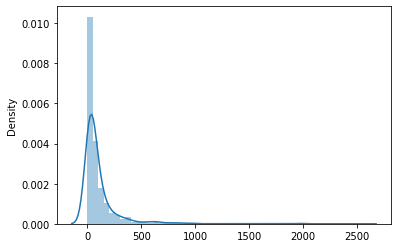

In [8]:
doc_lengths = []

for review in review_df:

    # get rough token count distribution
    tokens = nltk.word_tokenize(review)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [9]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.015

In [10]:
np.average(doc_lengths)

105.347

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [11]:
# Load the GPT tokenizer.
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-small
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-small
# tokenizer_medium = GPT2Tokenizer.from_pretrained('gpt2-medium') #gpt2-medium
# tokenizer_large = GPT2Tokenizer.from_pretrained('gpt2-large') #gpt2-large




Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


Word Token Embeddings 
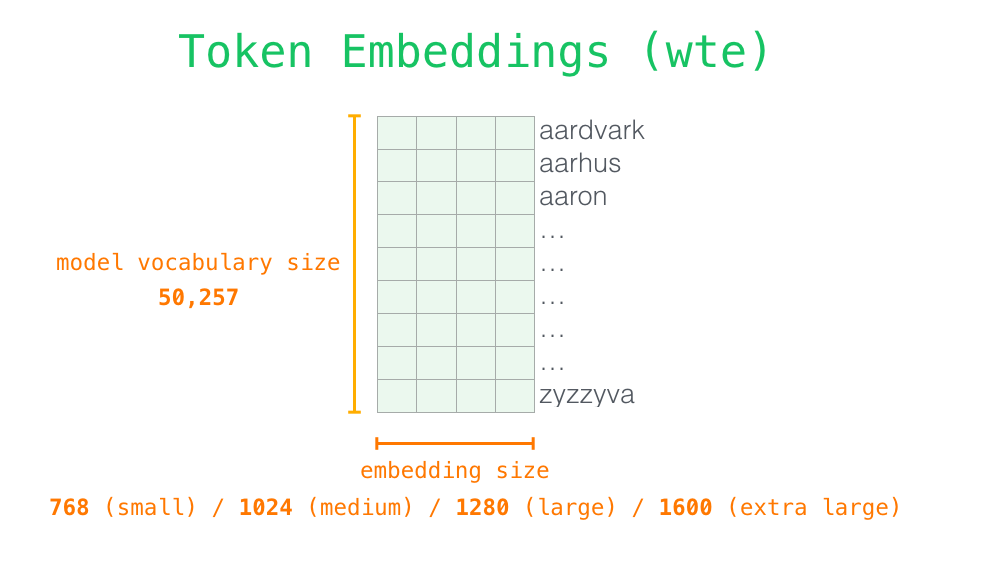

# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has led to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.
Read [here](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation#:~:text=Gradient%20accumulation%20is%20a%20technique,of%20batches%20have%20been%20performed.)

In [13]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [14]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [22]:
dataset = GPT2Dataset(review_df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  900 training samples
  100 validation samples


In [23]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [24]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 5600

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon #The epsilon is to avoid divide by zero error in the above equation while updating the variable when the gradient is almost zero.
                )

In [27]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [28]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

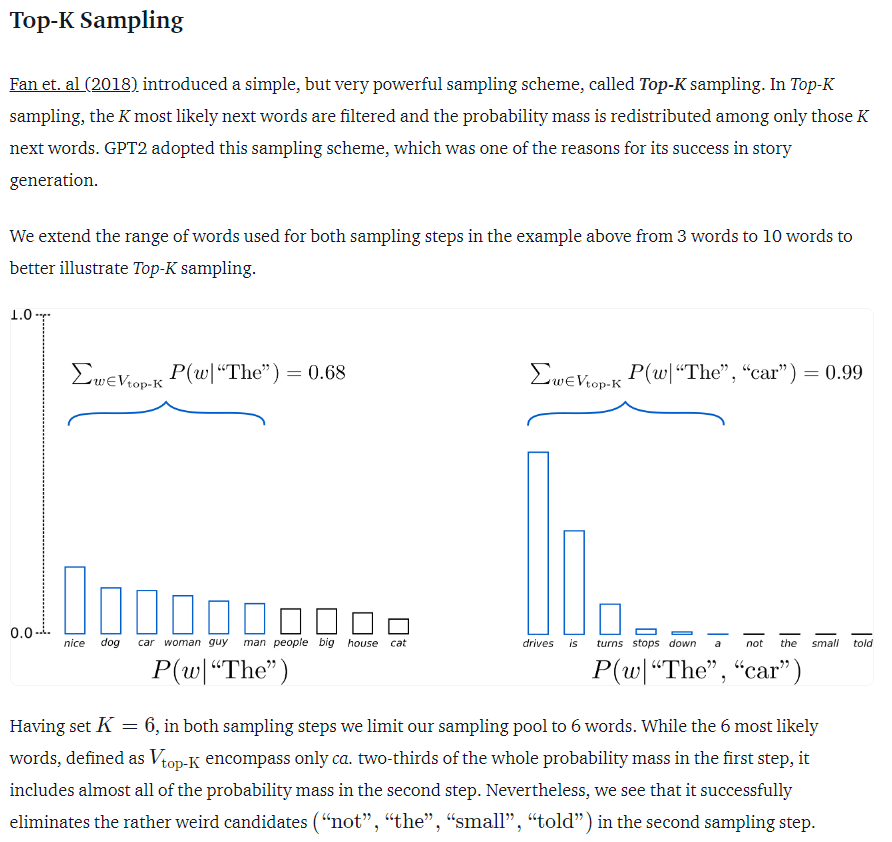

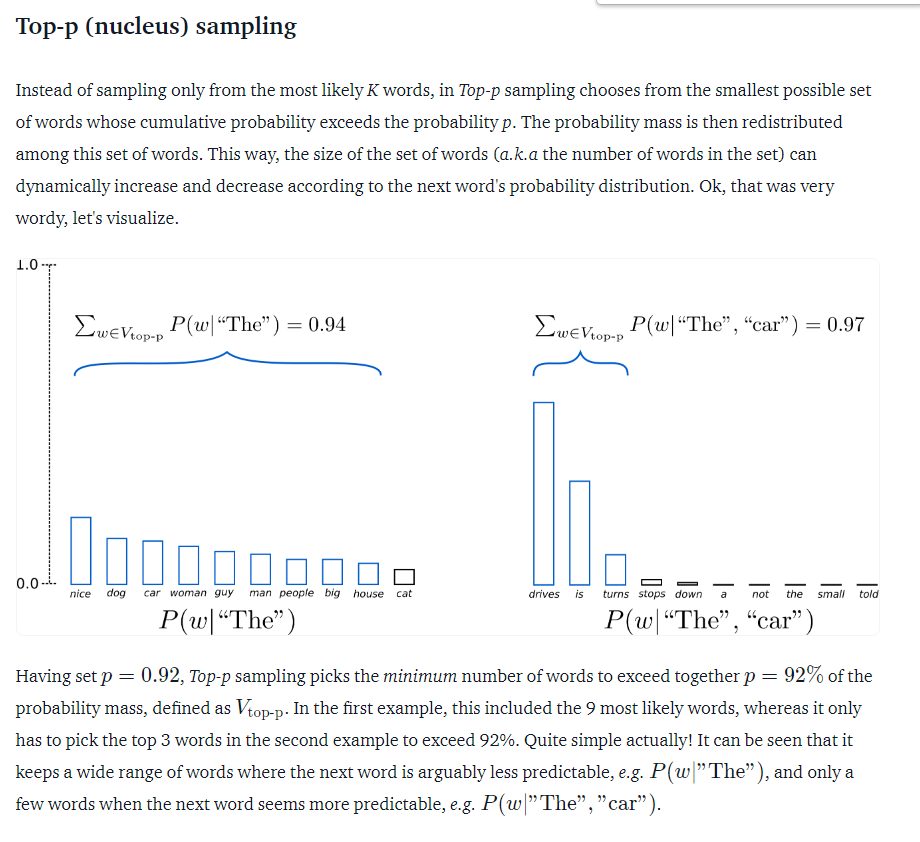

In [29]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.3617081940174103.   Elapsed: 0:00:51.
0:  stagedThe characters look like real people - it seems that they've been getting into the game since the beginning...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.6780374646186829.   Elapsed: 0:01:41.
0: uitsThe game is very helpful for getting to different core games. It offers the gameplay of a traditional hard-to-meacomotank system, and it allows for your computer to read your core data. This allows you to control your computer's system, and your PC's software.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.35587191581726074.   Elapsed: 0:02:32.
0: ensonI had hoped this game would be great! but it doesn't so. Now the only thing I do. is get this game.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.3834806978702545.   Elapsed: 0:03:23.
0:  lineThis is a nice product. It has a very nice color and a decent design. It has a nice design and does work great on small devices.   The batteries are very tight to charge. They are cheap and very cheap so far. There is a huge difference.    It is an awesome product for anyone. The case has a nice size. There is a small USB cable (one in the case, to get it to work) and the case is nice. It also has a case protector to protect the headphones as well.   Overall, a good product with a great price and a few nice features.

  Average training loss: 0.90
  Training epoch took: 0:03:50

Running Validation...
  Validation Loss: 0.43
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.32699906826019287.   Elapsed: 0:00:51.
0:  legallyIt's okay for someone to pick up this game on launch day. But it's still disappointing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.18939395248889923.   Elapsed: 0:01:42.
0:  lootGreat game!! I will buy again


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.026002801954746246.   Elapsed: 0:02:34.
0:  UsedNo complaints here,  just a few minor glitches.  If you haven't gotten the Comfort Plus Comfort Plus, get it now.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.3552376329898834.   Elapsed: 0:03:25.
0:  lefti am so happy this is a great game for the kids. i will say after playing it for 4 hours in a row for three days then i finally bought a 3DS and can play in 3 hours i'm done waiting for 4,3 hours!

  Average training loss: 0.45
  Training epoch took: 0:03:51

Running Validation...
  Validation Loss: 0.44
  Validation took: 0:00:08

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.24676205217838287.   Elapsed: 0:00:51.
0:  earnedThe game is a mix of role-playing games and RPG's; I consider myself to be a true RPG fanboy and have played many of them over the past few decades. My interest in RPGs started from Warcraft I bought the first two Warcraft, but I soon discovered that they weren't very long-lived; they were just the ones I made my own. With Warcraft, Blizzard gave me a new game mode, but it was a different experience. I'd spent my time collecting items, looting, and collecting gold, silver, and bronze and spending all of that on these things. The game world seems completely pointless now, with constant fighting for control of your nation and taking on various races for the Horde. So, I put all my money into my next-gen Warcraft; Blizzard. After grinding at least a few maps, leveling, and playing WoW, I was forced to turn to newer strategies, and instead of getting a new character, I instead pick up a leveled version of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.5074425339698792.   Elapsed: 0:01:45.
0:  fantI like the music and the graphics and the story. I mean the graphics are well done and the voice acting in this game is superb. I will definitely buy any RPG out there and will enjoy it. This is a good game and has the potential to become a must buy for any RPG enthusiast.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.24334034323692322.   Elapsed: 0:02:37.
0:  forceA game for everyone


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.6472142934799194.   Elapsed: 0:03:28.
0:  SpectThis was my first time playing MW2. It was my favorite game of the year. The graphics were good to the point where I am not even going to recommend this game to a person that has never played MW2. I highly suggest this game to ANYONE.

  Average training loss: 0.38
  Training epoch took: 0:03:54

Running Validation...
  Validation Loss: 0.46
  Validation took: 0:00:08

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.18188542127609253.   Elapsed: 0:00:51.
0:  significantWe got a Gamecube Bundle for our son and his friend, Mario. The games in it are pretty good, he has not liked them but is happy to have them both like this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.14920087158679962.   Elapsed: 0:01:43.
0:  aerialGame is awesome and is definetly better than the other MMORPG of it's kind. The only thing lacking in my rating is Skyrim and Dovahkiin. If only there were an expansion that actually made sense, instead of the DLC that ruined Skyrim.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.2895055413246155.   Elapsed: 0:02:35.
0:  BidenIf you look at the top 10 score cards, they're all about poker. This is the best. You can play 2-4 poker for free at any time. All in all, this is a great game.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.06805963814258575.   Elapsed: 0:03:27.
0:  resultedGameplay has always been about exploration and exploration.  The action and exploration are superb.  The graphics are great, but they are just a little dated from previous XBOX games.  The controls for exploration and jumping are clumsy at times.  There is a short and sweet touch in that you can take your XBOX to hell if you take too long.  You do not have to worry about anything, just don't waste it.  For the price you paid for this PSP, I would recommend this PSP.

  Average training loss: 0.31
  Training epoch took: 0:03:53

Running Validation...
  Validation Loss: 0.49
  Validation took: 0:00:08

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.3915712833404541.   Elapsed: 0:00:51.
0:  NoIf you love Japanese games you will like this one. It does include some action but it doesn't have that many scenes. This game is okay because the story is really long and the action is really intense, but you'll forget about the story altogether for a half hour.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.13550807535648346.   Elapsed: 0:01:43.
0:  robotThis game was an amazing experience


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.3596384525299072.   Elapsed: 0:02:35.
0: ilyNo complaints, works perfectly


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.28513479232788086.   Elapsed: 0:03:26.
0:  SometimesFirst off let me say this is definately one of the best games I have played. It took me a while to figure out, but by leaps and bounds I managed to accomplish almost all of the tasks that the game requires you to complete. With the exception of some missions, which are extremely difficult to accomplish and will require extremely high skill to complete, you're pretty much done with the game. The graphics and music for this game is really, really good. The missions where really challenging and will require very little skill are: Multiplayer fights, side mission and capture the plant. It is one of the best games I have ever played! I got this game for a lot of money, though, and it will do that in the near future.

  Average training loss: 0.25
  Training epoch took: 0:03:53

Running Validation...
  Validation Loss: 0.53
  Validation took: 0:00:08

Training complete!
Total training took 0:20:02 (h:mm:ss)

Let's view the summary of the training process.

In [30]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.90,0.43,0:03:50,0:00:08
2,0.45,0.44,0:03:51,0:00:08
3,0.38,0.46,0:03:54,0:00:08
4,0.31,0.49,0:03:53,0:00:08
5,0.25,0.53,0:03:53,0:00:08


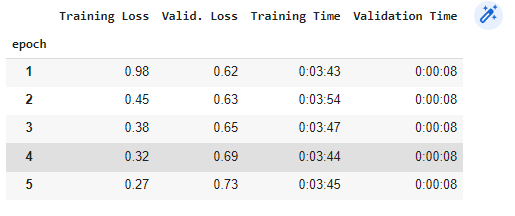

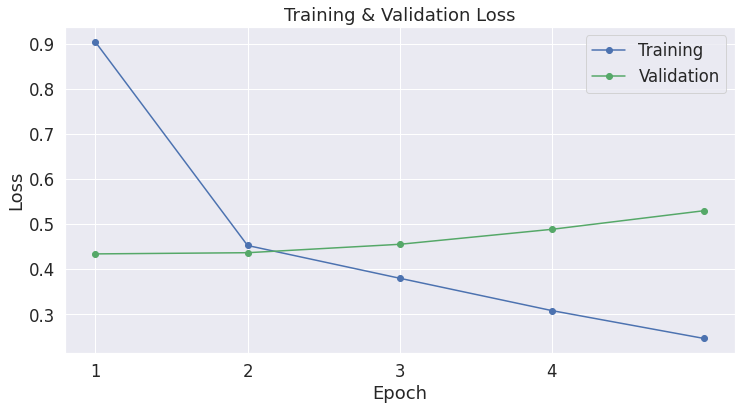

In [31]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/KDM-ICP12'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/KDM-ICP12


('/content/drive/MyDrive/KDM-ICP12/tokenizer_config.json',
 '/content/drive/MyDrive/KDM-ICP12/special_tokens_map.json',
 '/content/drive/MyDrive/KDM-ICP12/vocab.json',
 '/content/drive/MyDrive/KDM-ICP12/merges.txt',
 '/content/drive/MyDrive/KDM-ICP12/added_tokens.json',
 '/content/drive/MyDrive/KDM-ICP12/tokenizer.json')

In [36]:
!ls -l --block-size=K "/content/drive/MyDrive/KDM-ICP12/"

total 501732K
-rw------- 1 root root      1K Nov 25 00:01 added_tokens.json
drwx------ 2 root root      4K Nov 20 19:47 assig
-rw------- 1 root root      1K Nov 25 00:01 config.json
-rw------- 1 root root    446K Nov 25 00:01 merges.txt
-rw------- 1 root root 498441K Nov 25 00:01 pytorch_model.bin
-rw------- 1 root root      1K Nov 25 00:01 special_tokens_map.json
-rw------- 1 root root      1K Nov 25 00:01 tokenizer_config.json
-rw------- 1 root root   2059K Nov 25 00:01 tokenizer.json
-rw------- 1 root root    780K Nov 25 00:01 vocab.json


In [37]:
!ls -l --block-size=M "/content/drive/MyDrive/KDM-ICP12/pytorch_model.bin"

-rw------- 1 root root 487M Nov 25 00:01 /content/drive/MyDrive/KDM-ICP12/pytorch_model.bin


# Generate Text

In [38]:
PATH = '/content/drive/MyDrive/KDM-ICP12'

tokenizer = GPT2TokenizerFast.from_pretrained(PATH, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [39]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained(PATH, output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained(PATH, config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [40]:
model.eval()

prompt = "<|startoftext|>Pokemon Game"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 48034,  3776]], device='cuda:0')
0: Pokemon Game Cube is great, but I need to spend more money to get it. If you want to know more about getting Pokemon this is the place to do it. There are many different Pokas around, but for the most part this is the best. I love that I can live my own way without spending any money.


1: Pokemon Gamecube Gamecube is a great console but it is missing some of the functionality of the Gamecube Gamecube. This is a shame because this is the best way to play Pokemon in the DS.


2: Pokemon Gamecube/Gen 3/Wii U/Pikmin: The Movie is amazing, you can't get any more money out of this game besides Pokemon! The graphics are amazing, the control is super adorable. There is so much more to do than just a few moves, so many different types of Pokemon that make playing the game a snap! Great price!




These aren't bad at all!


# Assignment:

*   Finetune the model with another dataset (Wikipedia, IMDB, News, Yelp, Stories, ...) from HuggingFace's datasets library or another external source (Reddit, Twitter, Web Scrape, ...).
* Increase the size instead of 1,000 samples (might be time-consuming)
* Report generation with different parameters (`top_k, do_sample, top_p, temperature`) - Hint: https://huggingface.co/blog/how-to-generate
* Use another version of GPT if possible




# Creating Another dataset

In [41]:
pip install six==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
pip install apache_beam mwparserfromhell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.2 MB 29.7 MB/s 
     |████████████████████████████████| 176 kB 72.5 MB/s 
     |████████████████████████████████| 151 kB 54.9 MB/s 
     |████████████████████████████████| 2.5 MB 65.8 MB/s 
     |████████████████████████████████| 278 kB 62.6 MB/s 
     |████████████████████████████████| 2.4 MB 48.6 MB/s 
     |████████████████████████████████| 506 kB 56.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=fcab4d625999d4965aecbd434f4b3f06c4d2c7951633801f0a5aedc799bd25bb
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=17b92fc7f9cf428a906fa12c27a06c4366452d0311e0d4c73f61e8981ae9a02e
  Stored in directory: /root/

In [1]:
!pip install apache-beam[interactive]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 31.0 MB/s 
     |████████████████████████████████| 186 kB 58.6 MB/s 
     |████████████████████████████████| 793 kB 57.5 MB/s 
     |████████████████████████████████| 423 kB 72.5 MB/s 
     |████████████████████████████████| 1.6 MB 64.8 MB/s 
  Created wheel for timeloop: filename=timeloop-1.0.2-py3-none-any.whl size=3720 sha256=cd48ca75645b0d3075b34170ff27514453513b165bd6e955dce2fab11f87b5e0
  Stored in directory: /root/.cache/pip/wheels/3a/7e/fc/5e4d6da12b9ab6550604412936723ec6f2faf7391dd6726a01
Successfully built timeloop
  Attempting uninstall: tornado
    Found existing installation: tornado 6.0.4
    Uninstalling tornado-6.0.4:
      Successfully uninstalled tornado-6.0.4
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
  Attemptin

In [1]:
from datasets import load_dataset

dataset_wiki = load_dataset("wikipedia", "20220301.bat-smg", beam_runner='DirectRunner')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?parquet files/s]

  0%|          | 0/1 [00:00<?, ?shards/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.bat-smg/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
dataset_wiki

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 17071
    })
})

In [3]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(5600)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2TokenizerFast, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        # print(column)

        if isinstance(typ, ClassLabel):
            print(column, typ.names)
            df[column] = df[column].transform(lambda i: typ.names[i])
    # display(HTML(df.to_html()))
    display(df.head(10))
    return df


In [5]:
sample_df = show_random_elements(dataset_wiki['train'], num_examples = 1000)
review_df = sample_df['text'].copy()

,id,url,title,text
0,21037,https://bat-smg.wikipedia.org/wiki/Santop%C4%93,Santopē,"() - gīvenvėitė Zarasū rajuonė, Tormanta seniū..."
1,32470,https://bat-smg.wikipedia.org/wiki/Kat%C4%97ls,Katėls,"Katėls ī tuokis dėdlis pouds, dėrbams ėš metal..."
2,16753,https://bat-smg.wikipedia.org/wiki/O%C5%BEkamo...,Ožkamonė,"() - gīvenvėitė Šėlotės rajuonė, Katītiū seniū..."
3,35616,https://bat-smg.wikipedia.org/wiki/L%C4%81bgal...,Lābgalē,"() - gīvenvėitė Ruokėškė rajuonė, Jūžėntu seni..."
4,23028,https://bat-smg.wikipedia.org/wiki/Var%C5%A1ov...,Varšovelė,"() - gīvenvėitė Traku rajuonė, Rūdėškiu seniūn..."
5,36617,https://bat-smg.wikipedia.org/wiki/Kodar%C4%97...,Kodarėškės,"() - Alītous rajuonė, Aluovės seniūnėjuo esont..."
6,25951,https://bat-smg.wikipedia.org/wiki/Lazd%C4%ABns,Lazdīns,"Lazdīns () īr krūms, katros prėklaus beržėniu ..."
7,8598,https://bat-smg.wikipedia.org/wiki/Ivan%C4%97%...,Ivanėškē (Peliednagē),"Ivanėškē () - Kiedainiu rajuonė, Pelėdnagiu se..."
8,14658,https://bat-smg.wikipedia.org/wiki/Latvel%C4%9...,Latvelē (Kretinga),"Latvelē () - gīvenvėitė Kretingas rajuonė, Dar..."
9,10120,https://bat-smg.wikipedia.org/wiki/Paulios%20G...,Paulios Grībauskis,Grībauskis Paulios (g. 1984 m. bėrželė 2 d.) ī...


In [6]:
review_df

0      () - gīvenvėitė Zarasū rajuonė, Tormanta seniū...
1      Katėls ī tuokis dėdlis pouds, dėrbams ėš metal...
2      () - gīvenvėitė Šėlotės rajuonė, Katītiū seniū...
3      () - gīvenvėitė Ruokėškė rajuonė, Jūžėntu seni...
4      () - gīvenvėitė Traku rajuonė, Rūdėškiu seniūn...
                             ...                        
995    () - gīvenvėitė Kazlu Rūduos savivaldībie, Kaz...
996    Vuoseliūnā () - gīvenvėitė Prėinū rajuonė, Jėi...
997    Bėrželė 13 dėina īr 164 metu dėina (kelamasēs ...
998    () - gīvenvėitė Kretingas rajuonė, Darbienu se...
999    () - gīvenvėitė Šėlotės rajuonė, Katītiū seniū...
Name: text, Length: 1000, dtype: object

In [7]:
import nltk
import numpy as np
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


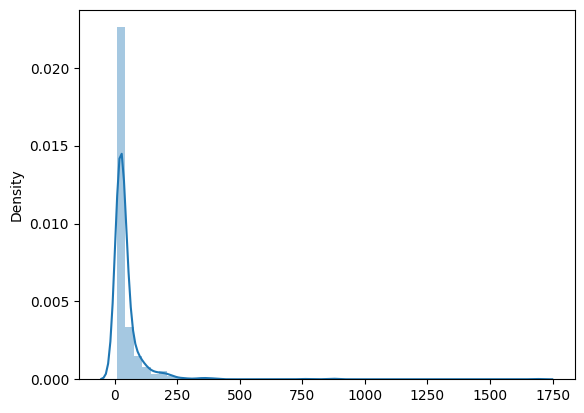

In [8]:
doc_lengths = []

for review in review_df:

    # get rough token count distribution
    tokens = nltk.word_tokenize(review)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [9]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.003

In [10]:
np.average(doc_lengths)

46.572

# GPT-2 Tokenizer

In [11]:
# Load the GPT tokenizer.
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-small
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-small
# tokenizer_medium = GPT2Tokenizer.from_pretrained('gpt2-medium') #gpt2-medium
# tokenizer_large = GPT2Tokenizer.from_pretrained('gpt2-large') #gpt2-large

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders

In [13]:
batch_size = 2

In [14]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [15]:
dataset = GPT2Dataset(review_df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  900 training samples
  100 validation samples


In [16]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [17]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 5600

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon #The epsilon is to avoid divide by zero error in the above equation while updating the variable when the gradient is almost zero.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [22]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    temperature=0.7,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.2798307538032532.   Elapsed: 0:00:49.
0:  stagedGestures - giestals - giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giestal giest


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.4611307382583618.   Elapsed: 0:01:40.
0: uitsTroubles - 4 katros, gīvenvėitė Trombojė, Šemaitės, Vėlniaus seniūnėjuo.

Troubles - 6 katros, gīvenvėitės Trombojė, Gīvenvėitės gīvena 34 žmuonis.

Troubles - 6 katros, gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.8773689866065979.   Elapsed: 0:02:31.
0: enson() - gīvenvėitė Šėlniaus rajuonė, Šėlniaus rajuona gīvena 13 žmuoniū.

Istuorėjė
2001 metās gīvenvėitie gīvena 13 žmuoniū.

Šėlniaus rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.29982781410217285.   Elapsed: 0:03:22.
0:  lineGėlkės () - gīvenvėitė Šėlniaus rajuonė, Šėlniaus seniūnėjuo.

Šėlniaus rajuona gīvenvėitės

  Average training loss: 0.82
  Training epoch took: 0:03:48

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.45037102699279785.   Elapsed: 0:00:51.
0:  legally() - gīvenvėitė Vėlniaus rajuonė, Vežeikiu seniūnėjuo. Anuo gīven žmuogos.

Vėlniaus rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.12526841461658478.   Elapsed: 0:01:43.
0:  loot() - gīvenvėitė Vėlniaus rajuonė, Papėlės seniūnėjuo. Anuo gīven 3 prietelē.

Vėlniaus rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.42927074432373047.   Elapsed: 0:02:36.
0:  UsedBovėlē () - gīvenvėitė Kalvarėjės savėvaldībie, Kalvarėjės seniūnėjuo. Anuo 2001 metās nabgīvena žmuonis.

Kalvarėjės savivaldībės gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.04333822429180145.   Elapsed: 0:03:28.
0:  left() - gīvenvėitė Vėlniaus rajuonė, Šiauliū seniūnėjuo. Anuo 2001 metās gīvena 6 žmuonis.

Vėlniaus rajuona gīvenvėitės

  Average training loss: 0.43
  Training epoch took: 0:03:54

Running Validation...
  Validation Loss: 0.35
  Validation took: 0:00:08

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.21308882534503937.   Elapsed: 0:00:52.
0:  earned() - gīvenvėitė Traku rajuonė, Traku seniūnėjuo. Anuo 2001 metās gīvena 9 žmuonis.

Trakū rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.03383863344788551.   Elapsed: 0:01:44.
0:  fant() - gīvenvėitė Šalčėninku rajuonė, Pabares seniūnėjuo. Anuo gīven 111 prietelē.

Šalčėninku rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.08605244755744934.   Elapsed: 0:02:36.
0:  force() - gīvenvėitė Šėlotės rajuonė, Šėlotės seniūnėjuo. Anuo gīven 18 žmuonis.

Šėlotės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.3258032500743866.   Elapsed: 0:03:29.
0:  SpectGropė īr krėgol krepšėnė prasėikams pėitrītiu mieru, katrū gausė žmuonis.

Gropė īr mieru krepšėnė gėnės dėdliausė šaukla, katrū krepšėnė ėlgoma.

Žemaitėjė 

Žemaitėjė 

Žemaitėjės 

Žemaitėjės vaduovu krepšėnė īr vaduovu krepšėnė īr vaduovu krep

  Average training loss: 0.36
  Training epoch took: 0:03:56

Running Validation...
  Validation Loss: 0.36
  Validation took: 0:00:08

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.529147744178772.   Elapsed: 0:00:51.
0:  significantTautā () - gīvenvėitė Kelmės rajuonė, Kelmės apīlėnkiu seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 3 žmuonis.

Kelmės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.03110046125948429.   Elapsed: 0:01:44.
0:  aerialŠaltė̄nā () - gīvenvėitė Kelmės rajuonė, Papėlės seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 82 žmuonis.

Kelmės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.03521960601210594.   Elapsed: 0:02:37.
0:  Biden() - gīvenvėitė Vėlniaus rajuonė, Lavuorėškiū seniūnėjuo. Anuo 2001 metās gīvena 14 žmuoniū.

Vėlniaus rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.7725502848625183.   Elapsed: 0:03:29.
0:  resulted() - gīvenvėitė Kelmės rajuonė, Liuoliū seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 28 žmuonis.

Kelmės rajuona gīvenvėitės

  Average training loss: 0.32
  Training epoch took: 0:03:55

Running Validation...
  Validation Loss: 0.34
  Validation took: 0:00:08

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.10157474130392075.   Elapsed: 0:00:51.
0:  NoRaptuons () - gīvenvėitė Traku rajuonė, Uonoške seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 54 žmuonis.

Trakū rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.1877426654100418.   Elapsed: 0:01:44.
0:  robotIvanėškės () - gīvenvėitė Zarasū rajuonė, Sovēka seniūnėjuo. Anuo 2001 metās gīvena 1 žmuogos.

Zarasū rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.47459927201271057.   Elapsed: 0:02:36.
0: ily() - gīvenvėitė Vėlniaus rajuonė, Mėckūnū seniūnėjuo. Anuo 2001 metās gīvena 3 žmuonis.

Vėlniaus rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.3566577732563019.   Elapsed: 0:03:28.
0:  Sometimes() - gīvenvėitė Zarasū rajuonė, Degotiū seniūnėjuo. Anuo 2001 metās gīvena 26 žmuonis.

Zarasū rajuona gīvenvėitės

  Average training loss: 0.28
  Training epoch took: 0:03:54

Running Validation...
  Validation Loss: 0.36
  Validation took: 0:00:08

Training complete!
Total training took 0:20:09 (h:mm:ss)


In [23]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.82,0.39,0:03:48,0:00:08
2,0.43,0.35,0:03:54,0:00:08
3,0.36,0.36,0:03:56,0:00:08
4,0.32,0.34,0:03:55,0:00:08
5,0.28,0.36,0:03:54,0:00:08


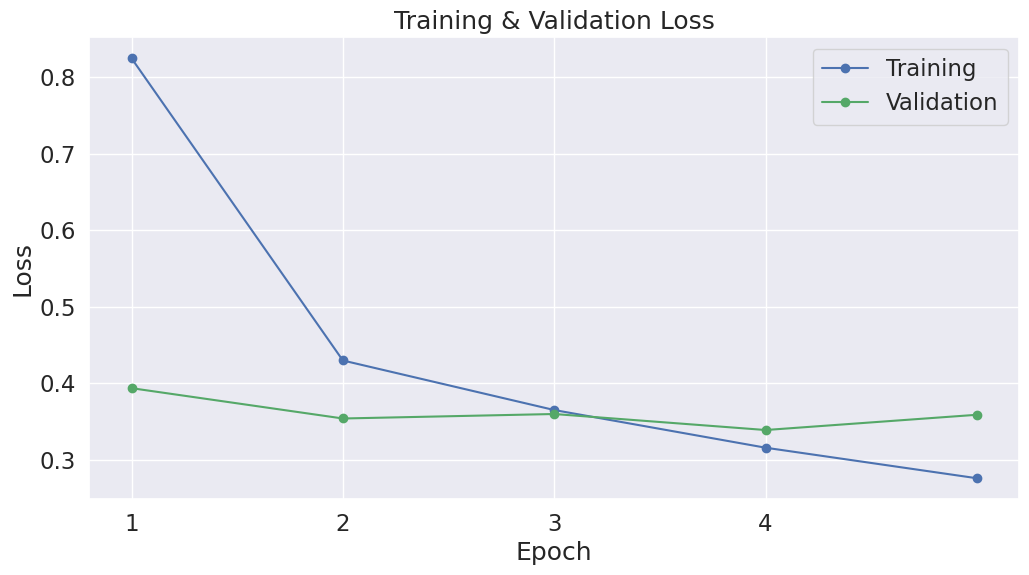

In [24]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-tune model

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/KDM-ICP12/assig'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/KDM-ICP12/assig


('/content/drive/MyDrive/KDM-ICP12/assig/tokenizer_config.json',
 '/content/drive/MyDrive/KDM-ICP12/assig/special_tokens_map.json',
 '/content/drive/MyDrive/KDM-ICP12/assig/vocab.json',
 '/content/drive/MyDrive/KDM-ICP12/assig/merges.txt',
 '/content/drive/MyDrive/KDM-ICP12/assig/added_tokens.json',
 '/content/drive/MyDrive/KDM-ICP12/assig/tokenizer.json')

In [28]:
!ls -l --block-size=K "/content/drive/MyDrive/KDM-ICP12/assig"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 501728K
-rw------- 1 root root      1K Nov 25 00:27 added_tokens.json
-rw------- 1 root root      1K Nov 25 00:27 config.json
-rw------- 1 root root    446K Nov 25 00:27 merges.txt
-rw------- 1 root root 498441K Nov 25 00:27 pytorch_model.bin
-rw------- 1 root root      1K Nov 25 00:27 special_tokens_map.json
-rw------- 1 root root      1K Nov 25 00:27 tokenizer_config.json
-rw------- 1 root root   2059K Nov 25 00:27 tokenizer.json
-rw------- 1 root root    780K Nov 25 00:27 vocab.json


In [29]:
!ls -l --block-size=M "/content/drive/MyDrive/KDM-ICP12/assig/pytorch_model.bin"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
-rw------- 1 root root 487M Nov 25 00:27 /content/drive/MyDrive/KDM-ICP12/assig/pytorch_model.bin


# Generate Text

In [30]:
PATH = '/content/drive/MyDrive/KDM-ICP12/assig'

tokenizer = GPT2TokenizerFast.from_pretrained(PATH, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [31]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained(PATH, output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained(PATH, config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [32]:
model.eval()

prompt = "<|startoftext|>Pokemon Game"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                temperature=0.7,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 48034,  3776]], device='cuda:0')
0: Pokemon GamePad (2009) īr Pinsirėninkės televėzėjės buokšta, žaidū seniūnėjuo. Anuo gīven 198 prietelē.

Pasėikėmā 

 1991: A Song for You (žaidū)
 1992: The Legend of the Dragonball Z (žaidu)
 1993: The Legend of the Dragonball Z (žaidu)
 1996: The Legend of the Dragonball Z (žaidu)
 2000: The Legend of the Dragonball Z (žaidu)
 2001: The Legend of the Dragonball Z (žaidu)
 2002: The Legend of the Dragonball Z (žaidu)
 2003: The Legend of the Dragonball Z (žaidu)
 2004: The Legend of the Dragonball Z (žaidu)
 2005: The Legend of the Dragonball Z (žaidu)
 2006: The Legend of the Dragonball Z (žaidu)

Pasėikėmā Lietuvuo

Pasėikėmā Svieti 

Pasėikėmā Svieti ikorts

Nūruodas 



1: Pokemon GamePad (2008, gīvenvėitė Šalčėninku) - miests Pėitū Kuoriejės pėitūs.

Pasėikėmā 
Pėitū Kuoriejės miestā


2: Pokemon Game Boy (žemaitėškā Pėitū Amerėkas Arabėjė) īr Pėitū Amerėkas Arabėjuo.

Istuorėjė
Pėitū Amerėkas Arabėjės žmuonis




# Using Another transformer
## GPT-2 Tokenizer

In [34]:
# Load the GPT tokenizer.
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-small
#tokenizer = GPT2TokenizerFast.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-small
# tokenizer_medium = GPT2Tokenizer.from_pretrained('gpt2-medium') #gpt2-medium
# tokenizer_large = GPT2Tokenizer.from_pretrained('gpt2-large') #gpt2-large
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("p208p2002/gpt2-squad-qg-hl", bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

model = AutoModelForCausalLM.from_pretrained("p208p2002/gpt2-squad-qg-hl")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [35]:
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The beginning of sequence token <|startoftext|> token has the id 50260
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50261


# Pytorch datset and dataloader

In [36]:
batch_size = 2

In [37]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [38]:
dataset = GPT2Dataset(review_df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  900 training samples
  100 validation samples


In [39]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [40]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 5600

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [41]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [42]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon #The epsilon is to avoid divide by zero error in the above equation while updating the variable when the gradient is almost zero.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [43]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [44]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [45]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.6418173909187317.   Elapsed: 0:00:49.
0:  staged[PAD][PAD][HL][HL][HL][PAD][HL][HL][HL][HL][HL][PAD][PAD][HL][HL][HL][HL][HL][HL][HL][HL][HL][HL][HL][HL][PAD]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 3.0996248722076416.   Elapsed: 0:01:40.
0: uits()uos, Vėalėalėėjuo,[PAD][PAD][PAD][PAD][PAD][HL][PAD]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.22213533520698547.   Elapsed: 0:02:33.
0: ensonValdos gīvenvėvenvaldēlės gīvenvėrajuona gīvenvėkalėmėš īvenvėitėnėšmuonis aug.
Kas gīvena.
Gīvenvė žmuonis


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.40584424138069153.   Elapsed: 0:03:24.
0:  line () - gīvenvė, ėšekarėjuo.





Istuorės

Vėkas.

Vėntėjėjėzėjėkas, ėitės. Anuo gīvenvėitėitės rajuorė.

Vėitėjės

  Average training loss: 1.11
  Training epoch took: 0:03:50

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.21718023717403412.   Elapsed: 0:00:51.
0:  legally () - gīvenvėitė Vėlniaus rajuonė, Mėškalīvenvėnėjuo. Anuo gīven 78 žmuonis. Vėrėlniaus rajuona gīvenvėitie gīvenvės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.09243156015872955.   Elapsed: 0:01:43.
0:  loot() - gīvenvėitė Kelmėjės seniūnėjuo.

Istuorėjės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.10753238946199417.   Elapsed: 0:02:35.
0:  UsedPėninku seniūnėjuo, Klaipiedas seniūnėjuo.

Istuorėjė
2001 metās gīvena 4 žmuonis.
Klaipiedas rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.4701478481292725.   Elapsed: 0:03:27.
0:  leftža nacės miests īr vuo. Uofėdėlgėninkė lėnies vuo. Apsėnūs.
Istuorėjės ė lietovuo.
Alėjės ėlges ėlniausūs. Vėlniausuos ė lietovėnės so ža: žr ožuori vuo.

Cėlniausiuomė
Svėlniausiu.

Dėlniausiuos ėlniausuos ėr būdėrviuos ėlniausiuos ėlniausės

  Average training loss: 0.56
  Training epoch took: 0:03:54

Running Validation...
  Validation Loss: 0.51
  Validation took: 0:00:08

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.057542834430933.   Elapsed: 0:00:51.
0:  earned
žerėndougėngas katra daug kaltenē. īr ėlgžerėndougā, bet žėndougā, dalėnė. šmuonė miesta būs daug kaltenē

Žemaitėka valstībū. Ša žerīndougā:
Švīgopėšėnā naugrā


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.06804046034812927.   Elapsed: 0:01:43.
0:  fantSaurėtė, kāp vīka ė bova vīka katras, kāp vakarėntīs katra ė vīka ėškāp niešarėkėp skaltenē.

Saurė ėškāp vīka ėškāp metās paukšt.
žīmėma ėškū paukštas.

Suodas (ėštēs paukštas) metās


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.29709285497665405.   Elapsed: 0:02:36.
0:  force. Mėsānės īr karpeniuosės gīvenvėitė Mažeikiu rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.3198859691619873.   Elapsed: 0:03:28.
0:  SpectGekuonā () - gīvenvėitė Kelmės rajuonė, Vėlkavėške seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 6 žmuonis.

Kelmės rajuona gīvenvėitės

  Average training loss: 0.45
  Training epoch took: 0:03:54

Running Validation...
  Validation Loss: 0.46
  Validation took: 0:00:08

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.6283358335494995.   Elapsed: 0:00:51.
0:  significant() - gīvenvėitė Šėlalės rajuonė, Papėrū seniūnėjuo. Anuo 2001 metās gīvena 13 žmuonis.

Šėlalės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.3896002173423767.   Elapsed: 0:01:44.
0:  aerialApsėcē 
Vėlniaus kaimalės (2016 metās gīvenvėitie). 

Istuorėjė
2001 metās gīvenvėitie gīvena 7 žmuonis.

Vėlniaus kaimalės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.2805529236793518.   Elapsed: 0:02:36.
0:  BidenPetrīžīnā () - gīvenvėitė Kelmės rajuonė, Vāgovas seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 35 žmuonis.

Kelmės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.28798848390579224.   Elapsed: 0:03:28.
0:  resultedGarsenītē () - gīvenvėitė Akmenės rajuonė, Lavuorėškiū seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 12 žmuoniū.

Akmenės rajuona gīvenvėitės

  Average training loss: 0.40
  Training epoch took: 0:03:55

Running Validation...
  Validation Loss: 0.44
  Validation took: 0:00:08

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.587410569190979.   Elapsed: 0:00:51.
0:  NoGegožėnės () - gīvenvėitė Kazlu Rūduos savivaldībie, Kazlu Rūduos seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 3 žmuonis.

Kazlū Rūduos savivaldībės gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.8914659023284912.   Elapsed: 0:01:43.
0:  robotVīotāsē () - gīvenvėitė Telšiū rajuonė, Pajares seniūnėjuo. Anuo 2001 metās gīvena 10 žmuoniū.

Telšiū rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.06434702128171921.   Elapsed: 0:02:35.
0: ilyNauksnē () - gīvenvėitė Kelmės rajuonė, Papėlės seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 25 žmuoniū.

Kelmės rajuona gīvenvėitės


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.093360424041748.   Elapsed: 0:03:27.
0:  Sometimes() - gīvenvėitė Prėinū rajuonė, Jėizna seniūnėjuo.

Istuorėjė
2001 metās gīvenvėitie gīvena 6 žmuonis.

Prėinū rajuona gīvenvėitės

  Average training loss: 0.37
  Training epoch took: 0:03:54

Running Validation...
  Validation Loss: 0.44
  Validation took: 0:00:08

Training complete!
Total training took 0:20:07 (h:mm:ss)


In [53]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.11,0.65,0:03:50,0:00:08
2,0.56,0.51,0:03:54,0:00:08
3,0.45,0.46,0:03:54,0:00:08
4,0.40,0.44,0:03:55,0:00:08
5,0.37,0.44,0:03:54,0:00:08


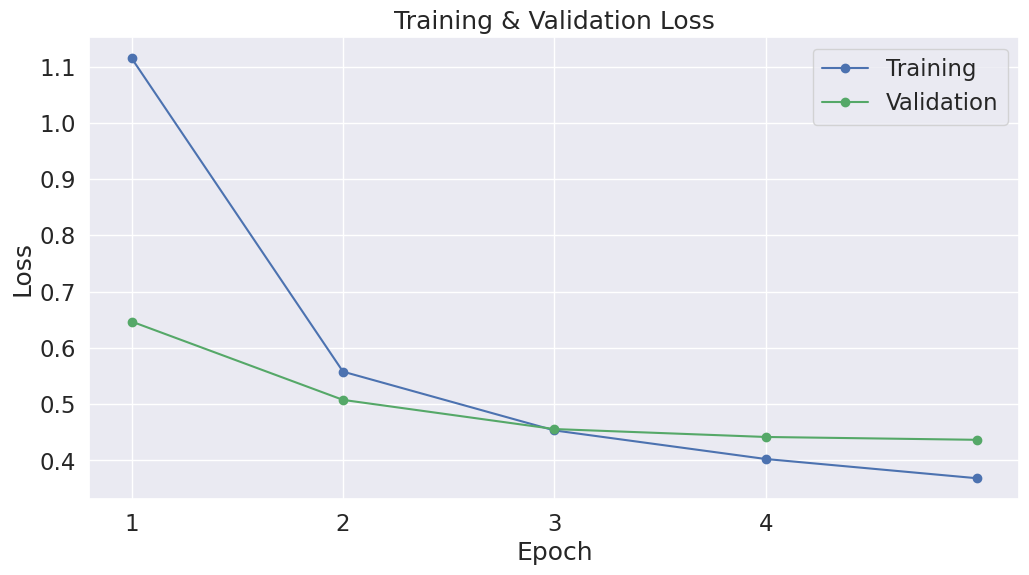

In [54]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [46]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50262, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-tune Model

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/KDM-ICP12/assig-2'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/KDM-ICP12/assig-2


('/content/drive/MyDrive/KDM-ICP12/assig-2/tokenizer_config.json',
 '/content/drive/MyDrive/KDM-ICP12/assig-2/special_tokens_map.json',
 '/content/drive/MyDrive/KDM-ICP12/assig-2/vocab.json',
 '/content/drive/MyDrive/KDM-ICP12/assig-2/merges.txt',
 '/content/drive/MyDrive/KDM-ICP12/assig-2/added_tokens.json',
 '/content/drive/MyDrive/KDM-ICP12/assig-2/tokenizer.json')

In [49]:
!ls -l --block-size=K "/content/drive/MyDrive/KDM-ICP12/assig-2"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ls: cannot access '/content/drive/MyDrive/KDM-ICP12/assig-12': No such file or directory


In [55]:
!ls -l --block-size=M "/content/drive/MyDrive/KDM-ICP12/assig-2/pytorch_model.bin"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
-rw------- 1 root root 487M Nov 25 01:18 /content/drive/MyDrive/KDM-ICP12/assig-2/pytorch_model.bin


# Generate Text

In [50]:
PATH = '/content/drive/MyDrive/KDM-ICP12/assig-2'

tokenizer = GPT2TokenizerFast.from_pretrained(PATH, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [51]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained(PATH, output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained(PATH, config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50262, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [52]:
model.eval()

prompt = "<|startoftext|>Pokemon Game"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50260, 48034,  3776]], device='cuda:0')
0: Pokemon Game Vierauskėjė īr oug rajuonė, Koržeikiū seniauobėnėjuo, asonėiū šmuota ėš kėtap pomtīka liousū.

Nutėkėmā šmuotē sėstemas ėš vakaruopa. Īr ėš žmuota anūgėnėškīvuonės pabėdliu kuo. 

Nutėkėmā šmuota pabėdliu.

Šatruo kalė pėdliu gesontė kompa, dėrb puolie.

Šaltė kėtas rajuona gīvenvėitės


1: Pokemon Gamerebauskas rajuonė, šiaurės seniūnėjuo, esontė gīvenvėitė. Anuo gīven 12 prieteliu.

Šiaurės savivaldībės gīvenvėitės


2: Pokemon Game U (g. 1977 m. Rijuonė, Rītauskaitis Jorbarka, Babtuonėjės ėš kėtėniučės).

Nūruodas 

Bamtuonėjės kėtėis jiedės,
Lietovuos rajuona gėmos centros, tėkretėns opėnms ons skėrts, sūruodas, ruodas, kėtūras.

Istuorėjė
Nūruodas 
Bamtuonėjės


